In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')
import tokamakTK
from tokamakTK import MyCounter, HUEOrder

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import statsmodels.api as sm
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import seaborn as sns
import plotly.express as px
import plotly.subplots as plsp
import plotly.graph_objects as go
from plotly.subplots import make_subplots


from collections import Counter

pd.set_option('display.max_columns', None)
plt.rc('font',family = 'serif')
TD_colors = plt.cm.get_cmap('flag', 20) #Paired, flag
colors_ = sns.color_palette('viridis', 20)
CSS_colors = [mcolors.to_hex(TD_colors(i)) for i in range(20)]
path = "../data/"

In [3]:
# Obtained from Optimization
min_subset_ids = pd.read_csv(path+"R_ids_alpha_0.6357.csv")

DB2 = pd.read_csv(path+"DB2P8.csv")
DB5 = pd.read_csv(path+"SELDB5_SVD.csv", low_memory=False) 

# Setting ELMy Dataset
DB5 = DB5[DB5["PHASE"].isin(['HGELM', 'HSELM', 'HGELMH', 'HSELMH'])]

# There is two shots from DB2P8 missing in DB5
missing_shots = DB2[~DB2.id.isin( DB5.id.values )].reset_index(drop=True)
DB5 = pd.concat([DB5, missing_shots], axis=0, ignore_index=True)

# Labeling shots that had great impact in decreasing alpha_R
DB5.insert(loc=2,column="label",value=[0]*len(DB5))
DB5.insert(loc=2,column="label_str",value=["Unaffected"]*len(DB5))
DB5.loc[(DB5[DB5.id.isin(min_subset_ids.id)].index), "label"] = 1
DB5.loc[(DB5[DB5.id.isin(min_subset_ids.id)].index), "label_str"] = "Decreasing"

print(
    f"{ round( (len(min_subset_ids)/len(DB5))*100     ,2)  }% of the data decreased alpha_R\n" + 
    f"{ round( (1 - len(min_subset_ids)/len(DB5))*100 ,2)  }% of the data did not decrease alpha_R"
)

23.45% of the data decreased alpha_R
76.55% of the data did not decrease alpha_R


In [4]:
DB5 = tokamakTK.clean_categorical_data(DB5)

In [5]:
# alpha_R -- 0.6358 --> when considering DB2 for calculation
data1 = DB5[DB5.label.isin([1])].reset_index(drop=True)
# alpha_R -- 2.1246 --> when considering DB2 for calculation
data2 = DB5[DB5.label.isin([0])]
# Removing DB2, because most of these shots have missing info
data2 = data2[~data2.id.isin(DB2.id.values)].reset_index(drop=True)

data = [data1,data2]

In [6]:
#tokamakTK.get_regression(data1, DB2)[1].summary()

In [7]:
# Needed for Improved Visualization in 2D Plots

HUE_ORDER = {}

HUE_ORDER["ICSCHEME"] = dict(zip(sorted(data1["ICSCHEME"].unique()), colors_[:len(data1["ICSCHEME"].unique())]))
HUE_ORDER["ELMTYPE"] = dict(zip(sorted(data1["ELMTYPE"].unique()), colors_[:len(data1["ELMTYPE"].unique())]))
HUE_ORDER["HYBRID"] = dict(zip(sorted(data1["HYBRID"].unique()), colors_[:len(data1["HYBRID"].unique())]))
HUE_ORDER["AUXHEAT"] = dict(zip(sorted(data1["AUXHEAT"].unique()), colors_[:len(data1["AUXHEAT"].unique())]))
HUE_ORDER["DIVMAT"] = dict(zip(sorted(data1["DIVMAT"].unique()), colors_[:len(data1["DIVMAT"].unique())]))
HUE_ORDER["WALMAT"] = dict(zip(sorted(data1["WALMAT"].unique()), colors_[:len(data1["WALMAT"].unique())]))
HUE_ORDER["EVAP"] = dict(zip(sorted(data1["EVAP"].unique()), colors_[:len(data1["EVAP"].unique())]))
HUE_ORDER["ECHMODE"] = dict(zip(sorted(data1["ECHMODE"].unique()), colors_[:len(data1["ECHMODE"].unique())]))
HUE_ORDER["PELLET"] = dict(zip(sorted(data1["PELLET"].unique()), colors_[:len(data1["PELLET"].unique())]))
HUE_ORDER["CONFIG"] = dict(zip(sorted(data1["CONFIG"].unique()), colors_[:len(data1["CONFIG"].unique())]))
HUE_ORDER["LIMMAT"] = dict(zip(sorted(data1["LIMMAT"].unique()), colors_[:len(data1["LIMMAT"].unique())]))
HUE_ORDER["TOK"] = dict(zip(sorted(data1["TOK"].unique()), colors_[:len(data1["TOK"].unique())]))

# Needed for 3D plots
PX_ORDER = {}

PX_ORDER["ICSCHEME"] = dict(zip(sorted(data1["ICSCHEME"].unique()), CSS_colors[:len(data1["ICSCHEME"].unique())]))
PX_ORDER["ELMTYPE"] = dict(zip(sorted(data1["ELMTYPE"].unique()), CSS_colors[:len(data1["ELMTYPE"].unique())]))
PX_ORDER["HYBRID"] = dict(zip(sorted(data1["HYBRID"].unique()), CSS_colors[:len(data1["HYBRID"].unique())]))
PX_ORDER["AUXHEAT"] = dict(zip(sorted(data1["AUXHEAT"].unique()), CSS_colors[:len(data1["AUXHEAT"].unique())]))
PX_ORDER["DIVMAT"] = dict(zip(sorted(data1["DIVMAT"].unique()), CSS_colors[:len(data1["DIVMAT"].unique())]))
PX_ORDER["WALMAT"] = dict(zip(sorted(data1["WALMAT"].unique()), CSS_colors[:len(data1["WALMAT"].unique())]))
PX_ORDER["EVAP"] = dict(zip(sorted(data1["EVAP"].unique()), CSS_colors[:len(data1["EVAP"].unique())]))
PX_ORDER["ECHMODE"] = dict(zip(sorted(data1["ECHMODE"].unique()), CSS_colors[:len(data1["ECHMODE"].unique())]))
PX_ORDER["PELLET"] = dict(zip(sorted(data1["PELLET"].unique()), CSS_colors[:len(data1["PELLET"].unique())]))
PX_ORDER["CONFIG"] = dict(zip(sorted(data1["CONFIG"].unique()), CSS_colors[:len(data1["CONFIG"].unique())]))
PX_ORDER["LIMMAT"] = dict(zip(sorted(data1["LIMMAT"].unique()), CSS_colors[:len(data1["LIMMAT"].unique())]))
PX_ORDER["TOK"] = dict(zip(sorted(data1["TOK"].unique()), CSS_colors[:len(data1["TOK"].unique())]))


hue_order = HUEOrder(HUE_ORDER)

### Feature Importance

``` Python
['LCOULOMB', 'QCYL5', 'ENBI', 'POHM', 'OMEGACYCL', 'VOL', 'PFLOSS',
       'AMIN'   , 'PLTH', 'KAREA'    , 'PNBI'    , 'NESOL', 'EPS'   , 'HYBRID_HYBRID',
       'MEFF'  , 'WFFORM', 'DWDIA', 'HYBRID_UNKNOWN', 'PICRH', 'BEIMHD',
       'PECRH', 'HYBRID_YES', 'WMHD', 'ELMTYPE_TYPE-II', 'ZEFFNEO']
```


1. `LCOULOMB`: **Coulomb Logarithm**,  ln$\Lambda = 30.9 - $ln$(n^{0.5}/T)$
2. `QCYL5`: Cylindrical, the plasma safety factor at the 95% poloidal flux surface.
3. `ENBI`: Neutral beam energy weighted by power
4. `POHM`: Total Ohmic power. 
5. `OMEGACYCL`: **Ion Cyclotron Frequency**,  $\Omega_i = qB_t/M_{eff}$
6. `VOL`: **Plasma Volume**
7. `PFLOSS`:  Neutral beam power that is lost from the plasma through charge exchange and unconfined orbits.
8. `AMIN`: **Minor Radius**
9. `PLTH`: Estimated Loss Power corrected for charge exchange and unconfined orbit losses.
10. `KAREA`: Plasma elongation
11. `PNBI`: Total injected neutral beam power minus shine through. 
12. `NESOL`: Electron density in scrape-off layer.
13. `EPS`: Inverse Aspect Ratio
14. `HYBRID`: Flag for indicating whether the time point is a HYBRID mode.
15. `MEFF`: Effective atomic mass in AMU
16. `WFFORM`: Total fast ion energy due to NBI estimated from approximate formula. 
17. `DWDIA`: Time rate of change of the total plasma stored energy.
18. `PICRH`: iCRH power absorbed by the plasma
19. `BEIMHD`: Beta Shafranov. 
20. `PECRH`: ECRH power absorbed by the plasma
22. `WMHD`: Total plasma energy as determined by MHD equilibrium calculations
23. `ELMTYPE`: Type of ELMs
24. `ZEFFNEO`: Plasma effective charge as determined by neo-classical resistivity.




# LCOULOMB vs QCYL5

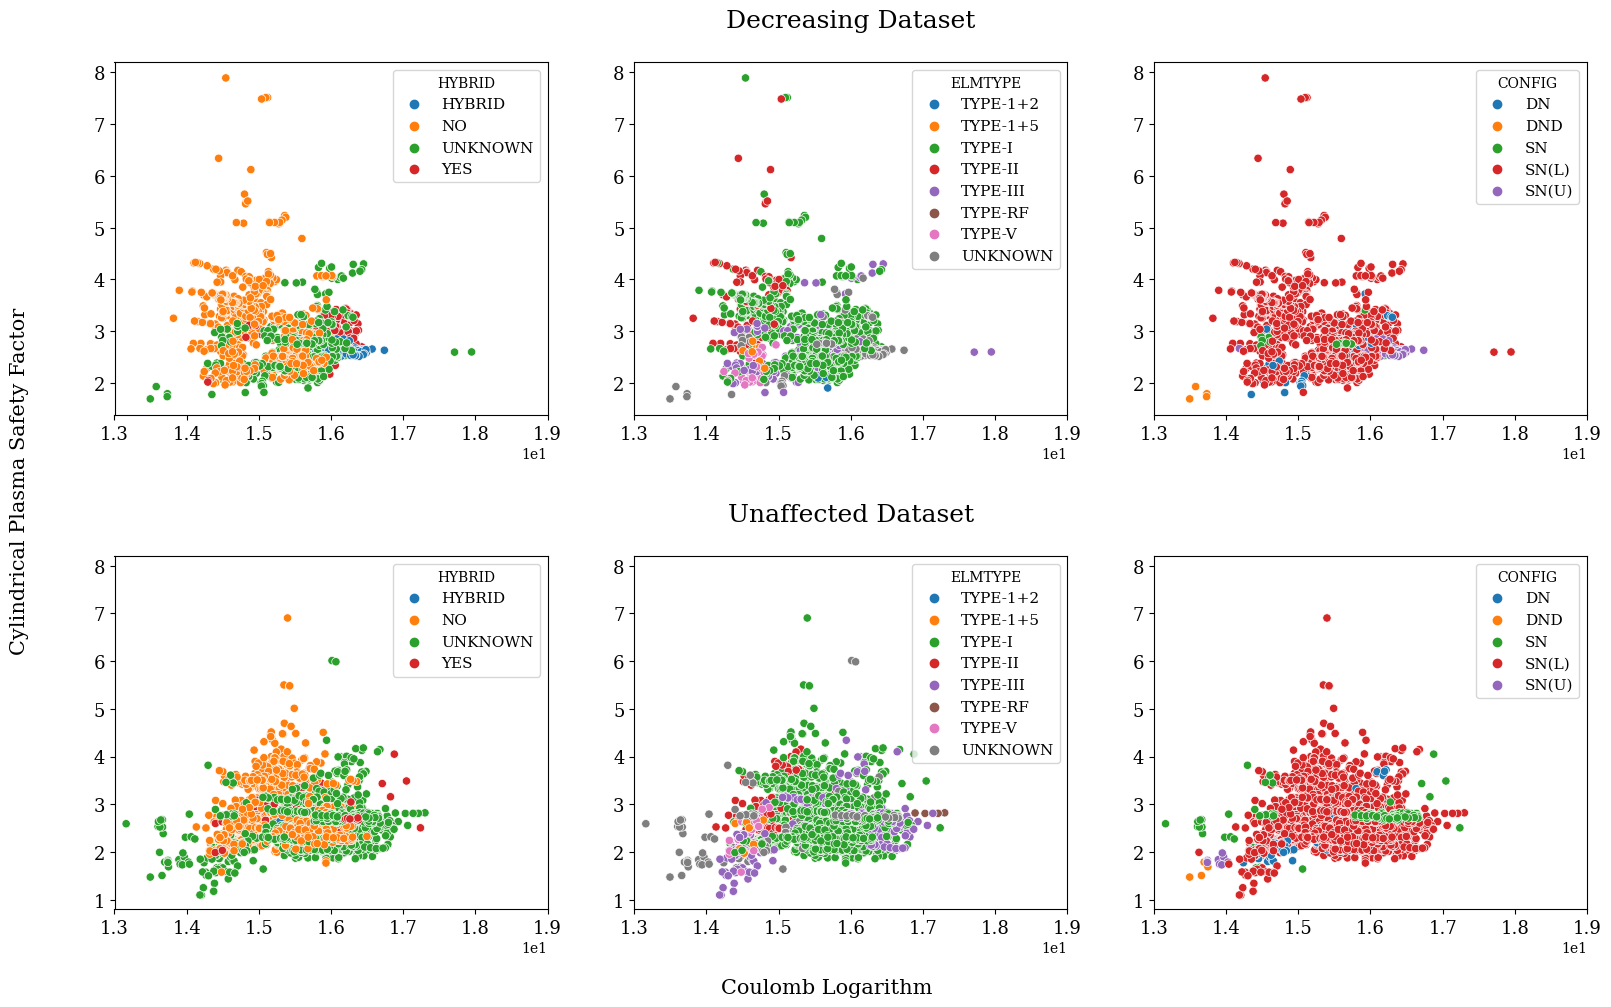

In [14]:
params = {
    "HUE_ORDER": HUE_ORDER,
    "cat_params": ["HYBRID", "ELMTYPE", "CONFIG"] ,
    "xy__params": ["LCOULOMB", "QCYL5"],
    "x___label": "Coulomb Logarithm" ,
    "y___label": "Cylindrical Plasma Safety Factor",
    "plot_size": (19, 11),
    "x__minmax": (1.3e1, 1.9e1),
    "y__minmax": (None, 8.2),
    "fig_format": "pdf",
    "save_fig": False
}

tokamakTK.scatter_data_comparison(data, params)

**Coulomb Logarithm**

 Is a measure of the strength of Coulomb interactions between charged particles in a plasma.
 
 * A "large" value of ln Λ indicates that the Coulomb interactions between particles are weak, and that particles are more likely to undergo long-range collisions rather than close encounters. In this regime, the mean free path of particles is long, and the plasma can behave like a fluid. Conversely, a "small" value of ln Λ indicates that the Coulomb interactions are strong, and that close encounters between particles are more frequent. In this regime, the mean free path of particles is short, and the plasma can behave like a kinetic gas.
 
* The typical range of values for ln Λ in a tokamak plasma is between 5 and 20, depending on the plasma density and temperature. However, large values of ln Λ can be much larger than this range, and are typically associated with low-density, high-temperature plasmas, such as those found in the solar corona or in laboratory fusion experiments. ln Λ values of 50 or greater are considered "large" and are typical in such plasmas.

---

**Safety Factor**

* A "large" value of q(0.95) indicates that the magnetic field lines in the plasma are tightly wound and that the plasma is more stable against MHD instabilities. The typical range of q(0.95) in tokamak plasmas is between 1 and 3. However, large values of q(0.95) can be much larger than this range, and are typically associated with high-performance, high-confinement plasmas. Typical large values of q(0.95) can be above 5 or even 10 in such plasmas.

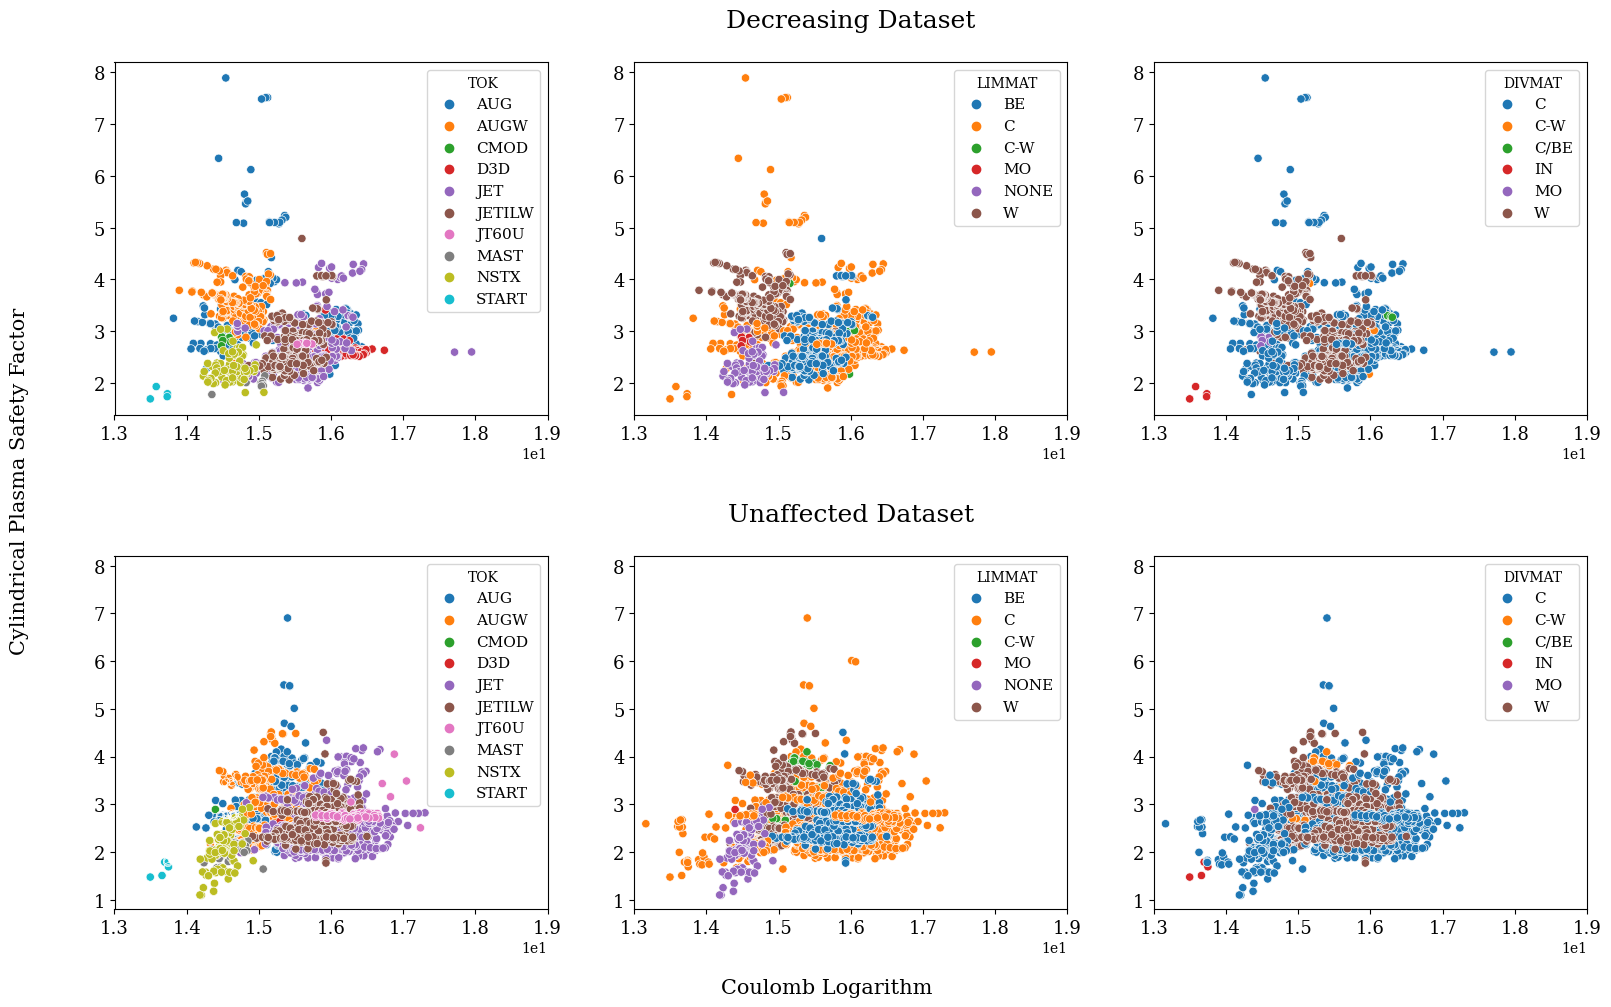

In [16]:
params = {
    "HUE_ORDER": HUE_ORDER,
    "cat_params": ["TOK", "LIMMAT", "DIVMAT"] ,
    "xy__params": ["LCOULOMB", "QCYL5"],
    "x___label": "Coulomb Logarithm" ,
    "y___label": "Cylindrical Plasma Safety Factor",
    "plot_size": (19, 11),
    "x__minmax": (1.3e1, 1.9e1),
    "y__minmax": (None, 8.2),
    "fig_format": "pdf",
    "save_fig": False
}

tokamakTK.scatter_data_comparison(data, params)

# ENBI vs POHM

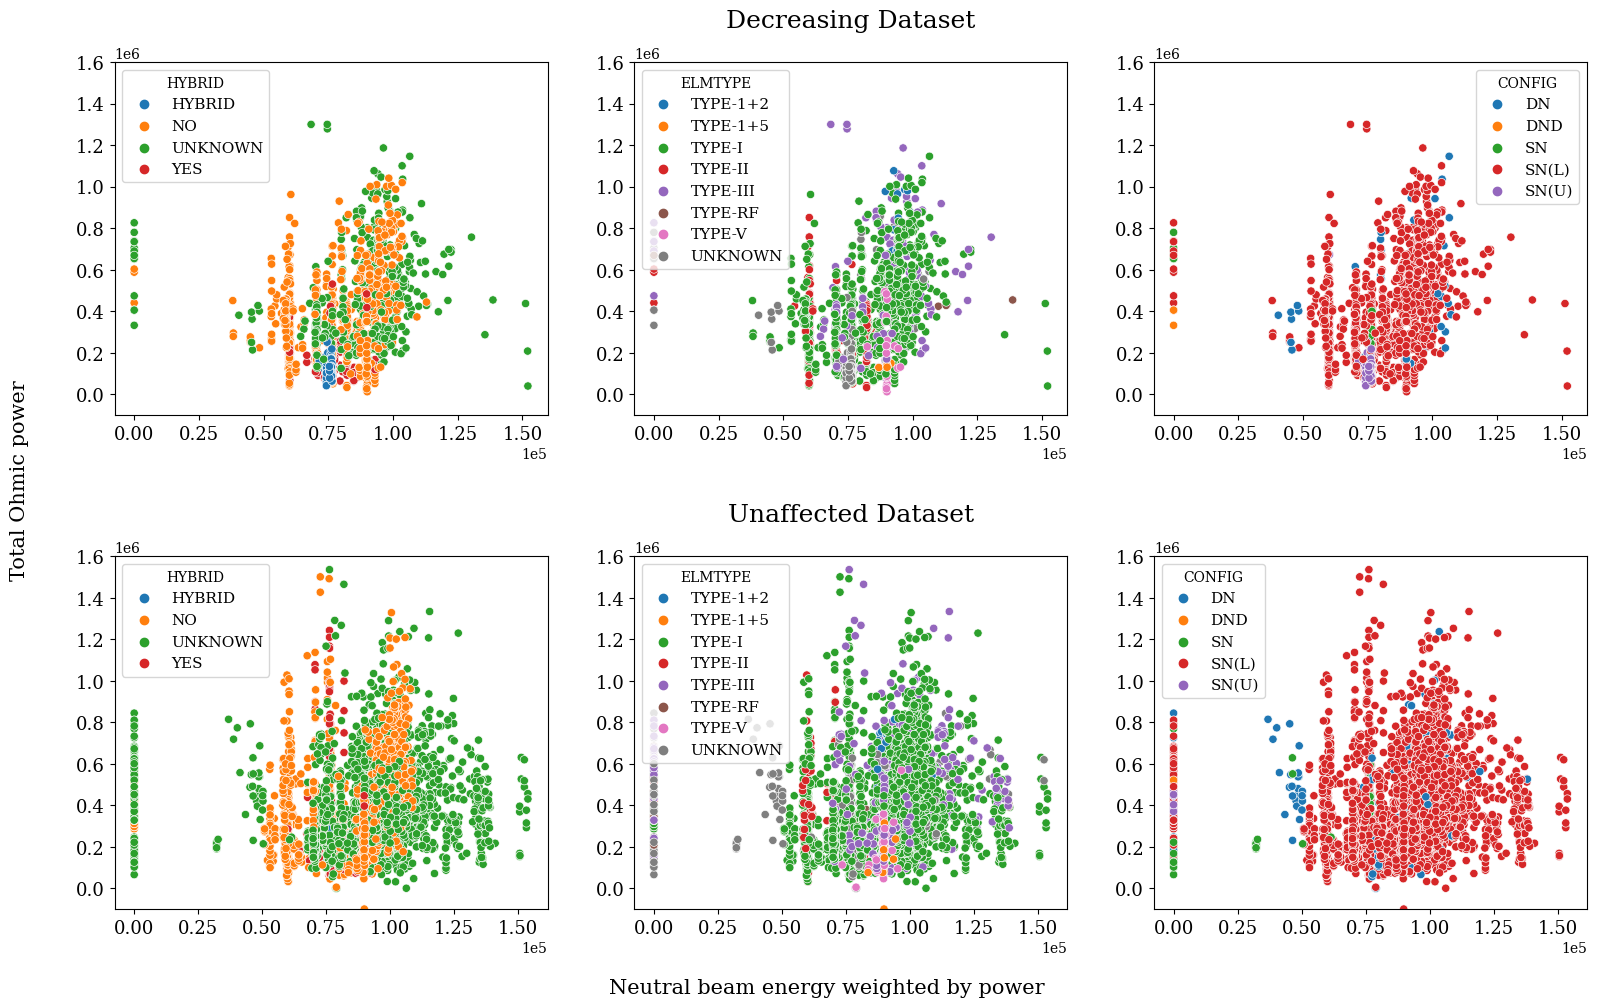

In [19]:
params = {
    "HUE_ORDER": HUE_ORDER,
    "cat_params": ["HYBRID", "ELMTYPE", "CONFIG"] ,
    "xy__params": ["ENBI", "POHM"],
    "x___label": "Neutral beam energy weighted by power" ,
    "y___label": "Total Ohmic power",
    "plot_size": (19, 11),
    "x__minmax": (None, None),
    "y__minmax": (-0.1e6, 1.6e6),
    "fig_format": "pdf",
    "save_fig": False
}

tokamakTK.scatter_data_comparison(data, params)

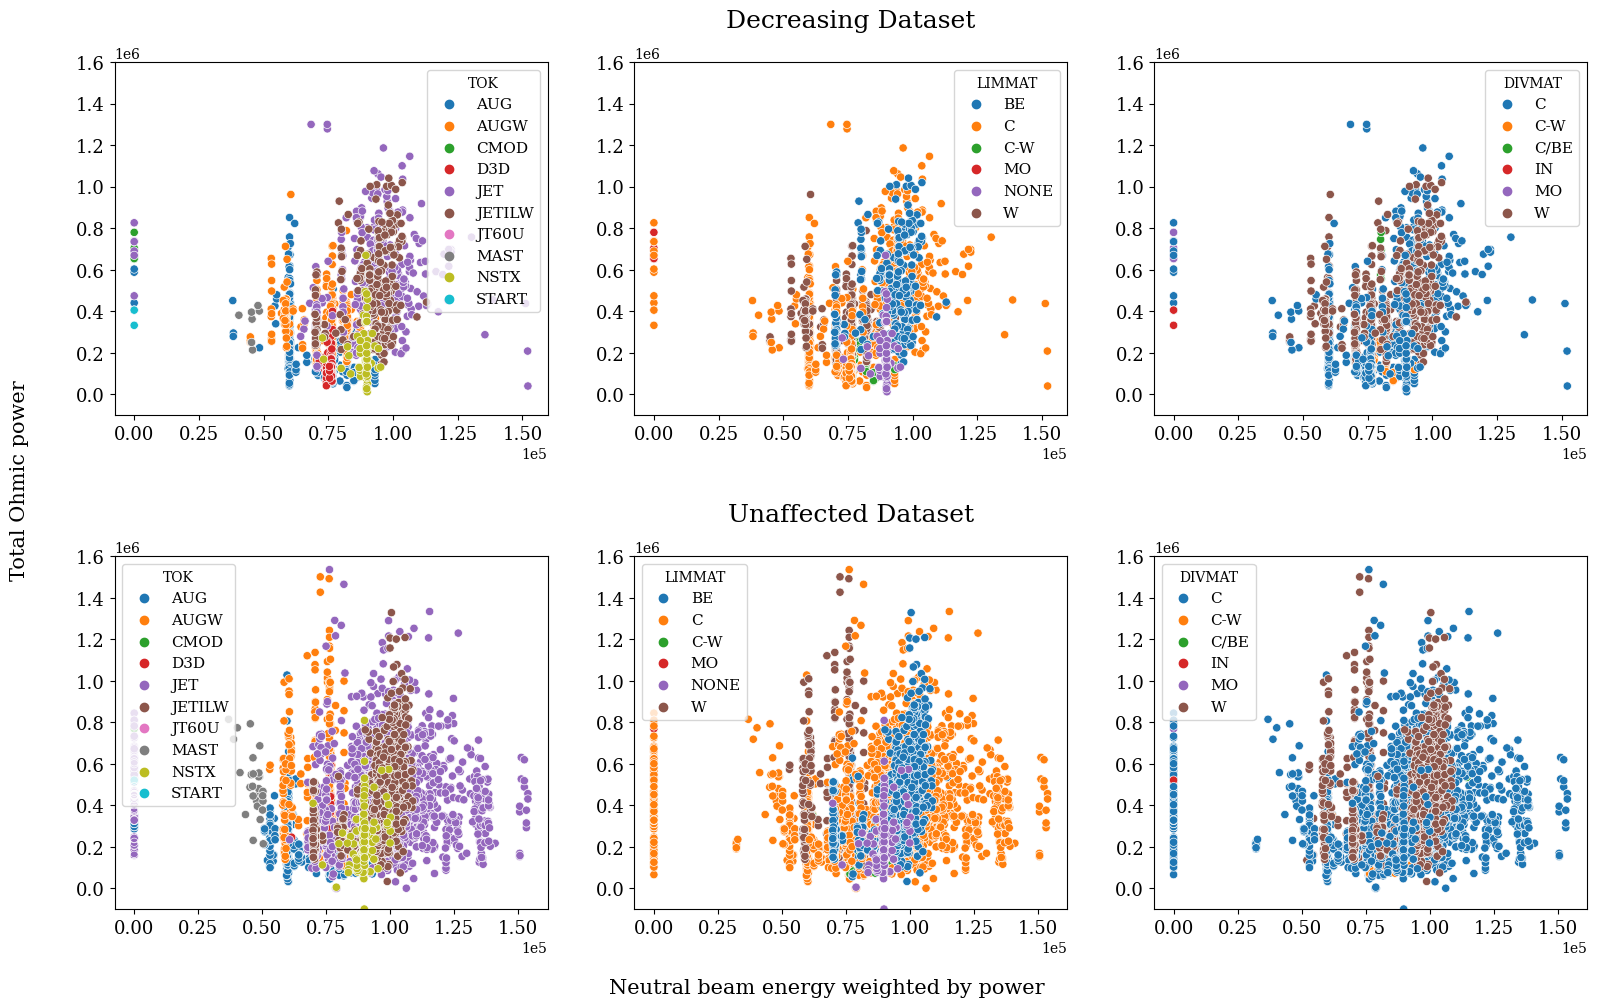

In [20]:
params = {
    "HUE_ORDER": HUE_ORDER,
    "cat_params": ["TOK", "LIMMAT", "DIVMAT"],
    "xy__params": ["ENBI", "POHM"],
    "x___label": "Neutral beam energy weighted by power" ,
    "y___label": "Total Ohmic power",
    "plot_size": (19, 11),
    "x__minmax": (None, None),
    "y__minmax": (-0.1e6, 1.6e6),
    "fig_format": "pdf",
    "save_fig": False
}

tokamakTK.scatter_data_comparison(data, params)

In [21]:
px.scatter_3d(data_frame=DB5, x="LCOULOMB", y="QCYL5", z="ENBI", 
              color="label_str", color_discrete_map={"Decreasing":"red","Unaffected":"black"})